In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import pickle
import time
import random
from google.colab import files
from PIL import Image

import tensorflow_datasets as tfds

import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,ReLU, Conv2DTranspose)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
import tensorflow as tf

def _parse_function(proto):
    feature_description = {
        'cam1_img': tf.io.FixedLenFeature([], tf.string),
        'cam2_img': tf.io.FixedLenFeature([], tf.string),
        'gen_img': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(proto, feature_description)

    cam1_img = tf.io.decode_jpeg(parsed_features['cam1_img'])
    cam2_img = tf.io.decode_jpeg(parsed_features['cam2_img'])
    pose_img = tf.io.decode_jpeg(parsed_features['gen_img'])
    label = parsed_features['label']

    # Convert uint8 images to float32


    return cam1_img, cam2_img, pose_img, label


In [ ]:

def load_dataset_from_tfrecord(filename):
    dataset = tf.data.TFRecordDataset(filenames=[filename])
    dataset = dataset.map(_parse_function)
    return dataset


trainloaded_dataset = load_dataset_from_tfrecord('/content/drive/MyDrive/cuhkreidtrain.tfrecord')

trainloaded_dataset = trainloaded_dataset.shuffle(buffer_size=1000)
trainloaded_dataset = trainloaded_dataset.batch(32)
trainloaded_dataset = trainloaded_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


for cam1_batch, cam2_batch, gen_batch,label in trainloaded_dataset.take(1):
    print("Cam1 batch shape:", cam1_batch.shape)
    print("Cam2 batch shape:", cam2_batch.shape)
    print("Pose batch shape:", gen_batch.shape)
    print("Label batch shape:", label.shape)


Cam1 batch shape: (32, 256, 128, 3)
Cam2 batch shape: (32, 256, 128, 3)
Pose batch shape: (32, 256, 128, 3)
Label batch shape: (32,)


In [ ]:
def load_dataset_from_tfrecord(filename):
    dataset = tf.data.TFRecordDataset(filenames=[filename])
    dataset = dataset.map(_parse_function)

    return dataset


testloaded_dataset = load_dataset_from_tfrecord('/content/drive/MyDrive/cuhkreidtest.tfrecord')

testloaded_dataset = testloaded_dataset.shuffle(buffer_size=1000)
testloaded_dataset = testloaded_dataset.batch(32)
testloaded_dataset = testloaded_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


for cam1_batch, cam2_batch, gen_batch, label in testloaded_dataset.take(1):
    print("Cam1 batch shape:", cam1_batch.shape)
    print("Cam2 batch shape:", cam2_batch.shape)
    print("Pose batch shape:", gen_batch.shape)
    print("Label batch shape:", label.shape)


Cam1 batch shape: (32, 256, 128, 3)
Cam2 batch shape: (32, 256, 128, 3)
Pose batch shape: (32, 256, 128, 3)
Label batch shape: (32,)


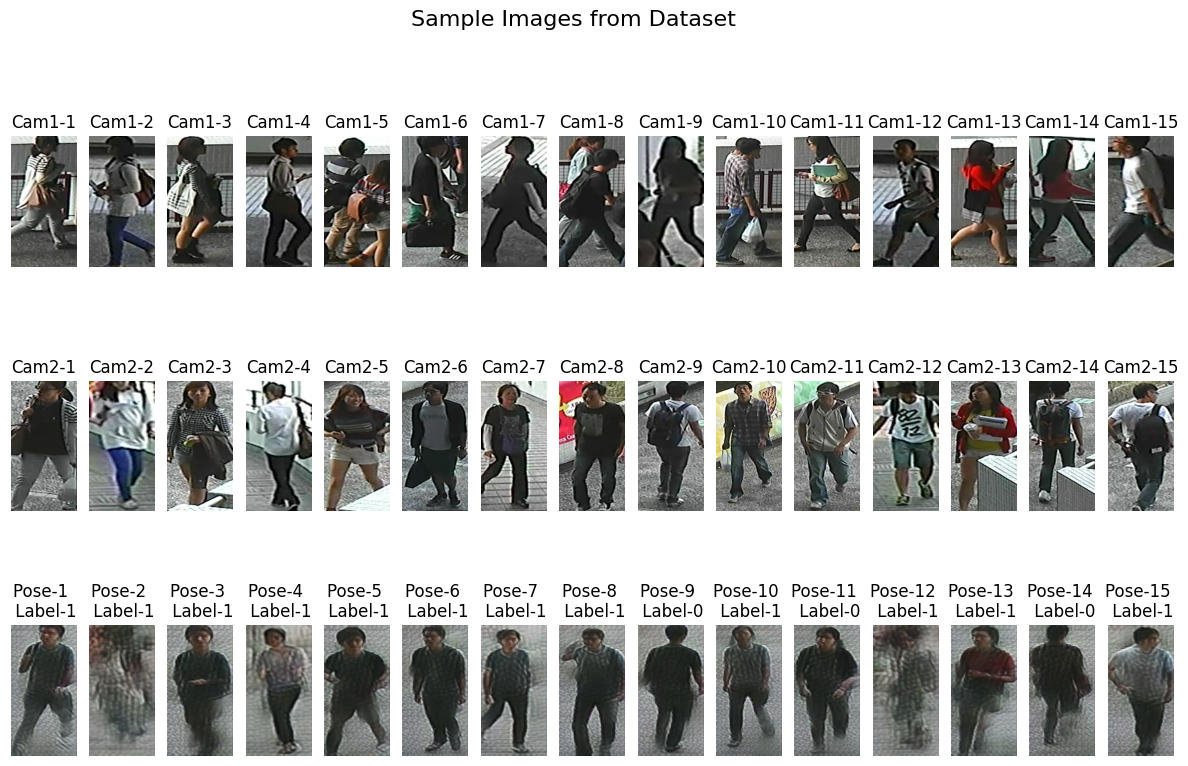

In [ ]:



import matplotlib.pyplot as plt


for cam1_batch, cam2_batch, gen_batch, label in testloaded_dataset.take(1):

    fig, axes = plt.subplots(3, 15, figsize=(15, 9))

    for i in range(15):

        axes[0, i].imshow(cam1_batch[i].numpy())
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Cam1-{i+1}")


        axes[1, i].imshow(cam2_batch[i].numpy())
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Cam2-{i+1}")


        axes[2, i].imshow(gen_batch[i].numpy())
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Pose-{i+1} \n Label-{label[i].numpy()}")


    fig.suptitle('Sample Images from Dataset', fontsize=16)

    plt.show()


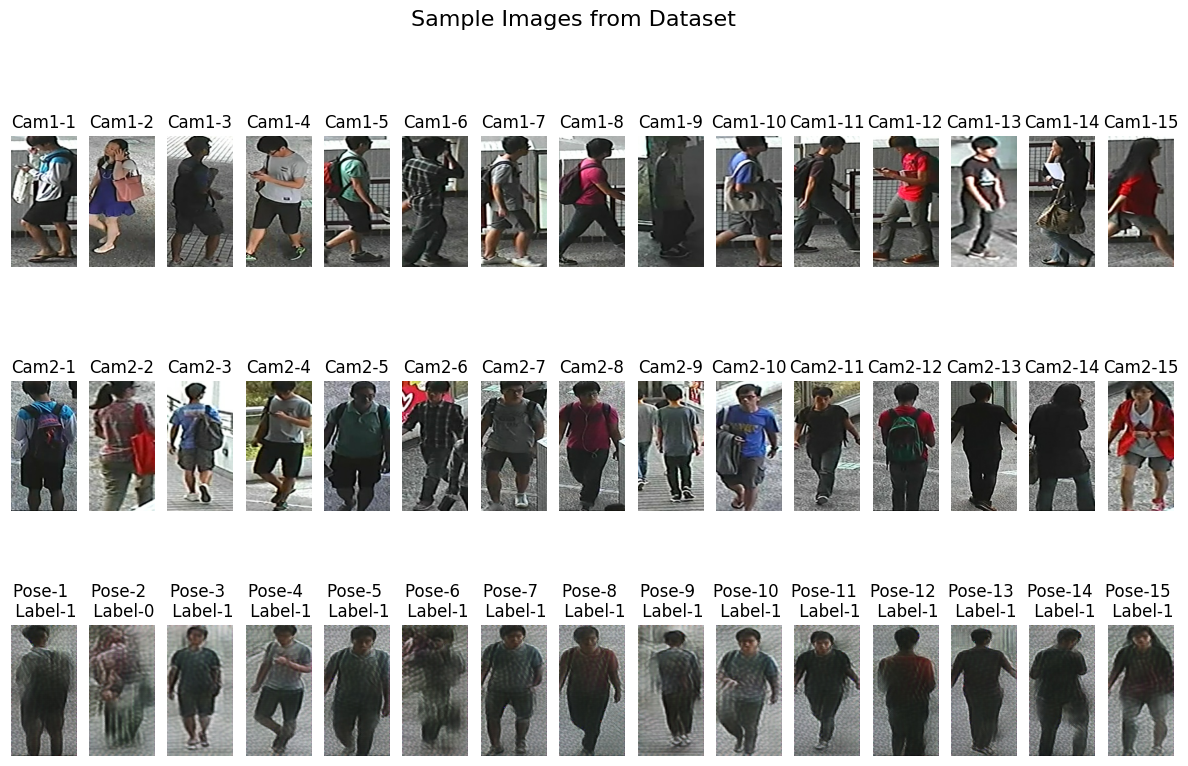

In [ ]:
import matplotlib.pyplot as plt


for cam1_batch, cam2_batch, gen_batch, label in trainloaded_dataset.take(1):

    fig, axes = plt.subplots(3, 15, figsize=(15, 9))

    for i in range(15):

        axes[0, i].imshow(cam1_batch[i].numpy())
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Cam1-{i+1}")


        axes[1, i].imshow(cam2_batch[i].numpy())
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Cam2-{i+1}")


        axes[2, i].imshow(gen_batch[i].numpy())
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Pose-{i+1} \n Label-{label[i].numpy()}")


    fig.suptitle('Sample Images from Dataset', fontsize=16)

    plt.show()


In [ ]:
one=0
zero=0
for cam1_batch, cam2_batch, gen_batch, label in testloaded_dataset.take(20):
  for i in range(32):
    print("Cam1 batch shape:", cam1_batch[i].shape)
    print("Cam2 batch shape:", cam2_batch[i].shape)
    print("Pose batch shape:", gen_batch[i])
    if (label[i]==1):
      one+=1
    else:
      zero+=1

print(one)
print(zero)

Streaming output truncated to the last 5000 lines.
  [0.5372549  0.5254902  0.5686275 ]
  [0.5529412  0.54509807 0.5882353 ]
  ...
  [0.5176471  0.5176471  0.5176471 ]
  [0.49803925 0.4784314  0.5019608 ]
  [0.49411768 0.47450984 0.5019608 ]]], shape=(256, 128, 3), dtype=float32)
Cam1 batch shape: (256, 128, 3)
Cam2 batch shape: (256, 128, 3)
Pose batch shape: tf.Tensor(
[[[0.57254905 0.54901963 0.5882353 ]
  [0.61960787 0.60784316 0.6431373 ]
  [0.6117647  0.6        0.63529414]
  ...
  [0.654902   0.6431373  0.67058825]
  [0.62352943 0.5882353  0.654902  ]
  [0.61960787 0.57254905 0.6509804 ]]

 [[0.57254905 0.54901963 0.5882353 ]
  [0.56078434 0.54901963 0.5764706 ]
  [0.57254905 0.5686275  0.5921569 ]
  ...
  [0.69803923 0.69411767 0.7176471 ]
  [0.72156864 0.7058824  0.7607844 ]
  [0.6509804  0.63529414 0.69411767]]

 [[0.627451   0.6156863  0.6431373 ]
  [0.6156863  0.6117647  0.6313726 ]
  [0.6039216  0.60784316 0.62352943]
  ...
  [0.70980394 0.73333335 0.73333335]
  [0.7372549

In [ ]:
def preprocess_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image

def preprocess_dataset(dataset):
    return dataset.map(lambda cam1, cam2, gen, label: (
        preprocess_image(cam1),
        preprocess_image(cam2),
        preprocess_image(gen),
        label
    ))


In [ ]:

trainloaded_dataset = preprocess_dataset(trainloaded_dataset)
testloaded_dataset = preprocess_dataset(testloaded_dataset)


In [ ]:
from collections import Counter
import numpy as np

# Assuming `trainloaded_dataset` contains labels as the last output
class_counts = Counter()
for _, _, _, label in trainloaded_dataset.as_numpy_iterator():
    class_counts.update(label.tolist())  # Convert the NumPy array to a list or individual elements

print("Class Distribution:", class_counts)

Class Distribution: Counter({1: 897, 0: 429})


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model


with tf.device('/device:GPU:0'):
  def build_resnet50_a():
      base_model_a = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
      layer_names = ['conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out']
      outputs_a = [base_model_a.get_layer(name).output for name in layer_names]
      x_a = Concatenate()(outputs_a)
      x_a = GlobalAveragePooling2D()(x_a)
      x_a = Dense(512)(x_a)
      x_a = BatchNormalization()(x_a)
      x_a = ReLU()(x_a)
      x_a = Dropout(0.5)(x_a)
      features_a = Dense(1, activation='sigmoid')(x_a)
      model_a = Model(inputs=base_model_a.input, outputs=features_a)
      return model_a

  def build_resnet50_b():
      base_model_b = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
      layer_names = ['conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out']
      outputs_b = [base_model_b.get_layer(name).output for name in layer_names]
      x_b = Concatenate()(outputs_b)
      x_b = GlobalAveragePooling2D()(x_b)
      x_b = Dense(512)(x_b)
      x_b = BatchNormalization()(x_b)
      x_b = ReLU()(x_b)
      x_b = Dropout(0.5)(x_b)
      features_b = Dense(1, activation='sigmoid')(x_b)
      model_b = Model(inputs=base_model_b.input, outputs=features_b)
      return model_b


  def contractive_loss(y_true, y_pred, model, lambda_=1e-4):
      weights = model.layers[-5].kernel
      l2_norm = tf.reduce_sum(tf.square(weights))
      bce_loss = tf.keras.losses.binary_crossentropy(y_true, tf.squeeze(y_pred))
      total_loss = bce_loss + lambda_ * l2_norm
      return total_loss





  def train_step(model, optimizer, x, y_true, lambda_=1e-4):
      with tf.GradientTape() as tape:
          y_pred = model(x, training=True)
          loss = contractive_loss(y_true, y_pred, model, lambda_)
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      return loss


  optimizer_a = tf.keras.optimizers.Adam()
  optimizer_b = tf.keras.optimizers.Adam()


  def train_model_with_contractive_loss(model, optimizer, dataset, epochs, lambda_=1e-4):
      for epoch in range(epochs):
          print(f"Epoch {epoch + 1}/{epochs}")
          for x, label in dataset:
              loss = train_step(model, optimizer, x, label, lambda_)
              print(f"Loss: {loss.numpy()}")


  model_a = build_resnet50_a()
  model_b = build_resnet50_b()






94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
with tf.device('/device:GPU:0'):
    model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    train_model_with_contractive_loss(model_a, optimizer_a, trainloaded_dataset.map(lambda cam1, cam2, gen, label: (cam1, label)), epochs=10)
    train_model_with_contractive_loss(model_b, optimizer_b, trainloaded_dataset.map(lambda cam1, cam2, gen, label: (cam2, label)), epochs=10)


    model_a.evaluate(testloaded_dataset.map(lambda cam1, cam2, gen, label: (cam1, label)))
    model_b.evaluate(testloaded_dataset.map(lambda cam1, cam2, gen, label: (cam2, label)))

Epoch 1/10
Loss: 0.6041058897972107
Loss: 0.7175268530845642
Loss: 0.5257081389427185
Loss: 0.7438751459121704
Loss: 0.48422691226005554
Loss: 0.5215715169906616
Loss: 0.578333854675293
Loss: 0.39721131324768066
Loss: 0.6119767427444458
Loss: 0.6927653551101685
Loss: 0.49829623103141785
Loss: 0.5268620252609253
Loss: 0.6283941864967346
Loss: 0.8757516741752625
Loss: 0.6886086463928223
Loss: 0.7172452211380005
Loss: 0.5036141872406006
Loss: 0.4802882671356201
Loss: 0.5565202832221985
Loss: 0.4406457841396332
Loss: 0.6080533862113953
Loss: 0.49440544843673706
Loss: 0.41895198822021484
Loss: 0.46641600131988525
Loss: 0.5193986892700195
Loss: 0.635455310344696
Loss: 0.7517979741096497
Loss: 0.41496503353118896
Loss: 0.44768238067626953
Loss: 0.5040110349655151
Loss: 0.5823215246200562
Loss: 0.6313894987106323
Loss: 0.5090258121490479
Loss: 0.49301543831825256
Loss: 0.5569925308227539
Loss: 0.5910210013389587
Loss: 0.5375619530677795
Loss: 0.38628116250038147
Loss: 0.45966479182243347
Loss:

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7596 - loss: 2.1433


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, ReLU, Lambda, GlobalAveragePooling2D, Multiply
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import cv2
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Feature extractor using ResNet50
def build_resnet50_base():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return Model(base_model.input, x)


# Combined Model for Binary Classification
def build_combined_model():
    # Feature extractors for both inputs
    resnet_cam1 = build_resnet50_base()
    resnet_cam2 = build_resnet50_base()

    # Inputs
    input_cam1 = Input(shape=(256, 128, 3))
    input_cam2 = Input(shape=(256, 128, 3))

    # Extract features
    cam1_features = resnet_cam1(input_cam1)
    cam2_features = resnet_cam2(input_cam2)

    # Feature difference and similarity
    diff_features = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([cam1_features, cam2_features])
    similarity_features = Multiply()([cam1_features, cam2_features])
    combined_features = tf.keras.layers.Concatenate()([diff_features, similarity_features])

    # Fully connected layers
    x = Dense(256)(combined_features)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)

    # Output layer for binary classification
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[input_cam1, input_cam2], outputs=output)


# Contrastive Loss Function
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, tf.float32)
    positive_loss = y_true * tf.square(y_pred)  # Minimize distance for similar pairs
    negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))  # Maximize distance for dissimilar pairs
    return tf.reduce_mean(positive_loss + negative_loss)


# Preprocessing Function for Images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 256))  # Resize image to (256, 128, 3)
    img = img / 255.0  # Normalize pixel values between 0 and 1
    return np.expand_dims(img, axis=0)  # Add batch dimension


# Visualization of Embeddings
def visualize_embeddings(model, dataset):
    embeddings = []
    labels = []

    for cam1, cam2, _, label in dataset.take(100):  # Limit for efficiency
        cam1_features = model.layers[2](cam1).numpy()  # Extract embeddings from ResNet
        cam2_features = model.layers[2](cam2).numpy()
        embeddings.append(cam1_features)
        embeddings.append(cam2_features)
        labels.append(label.numpy())
        labels.append(label.numpy())

    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(np.array(embeddings))

    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar()
    plt.title("t-SNE Visualization of Embeddings")
    plt.show()


# Training Function
def train_model(model, dataset, epochs, optimizer):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for cam1, cam2, _, label in dataset:
            # Forward and backward pass
            with tf.GradientTape() as tape:
                predictions = model([cam1, cam2], training=True)
                loss = contrastive_loss(label, predictions)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Accumulate metrics
            total_loss += loss.numpy() * label.shape[0]  # Batch loss scaled by batch size
            correct_predictions += tf.reduce_sum(
                tf.cast(tf.round(predictions) == tf.cast(label, tf.float32), tf.float32)
            ).numpy()
            total_samples += label.shape[0]

        # Compute average loss and accuracy for the epoch
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples * 100  # Convert to percentage
        print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4%}")


# Evaluation Function
def evaluate_model(model, dataset):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for cam1, cam2, _, label in dataset:
        predictions = model([cam1, cam2], training=False)
        loss = contrastive_loss(label, predictions)
        total_loss += tf.reduce_sum(loss).numpy()
        correct_predictions += tf.reduce_sum(tf.cast(predictions > 0.5, tf.int32) == tf.cast(label, tf.int32)).numpy()
        total_samples += label.shape[0]

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f"Evaluation - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4%}")


# Prediction Function
def predict(model, query_img_path, gallery_img_path):
    query_img = preprocess_image(query_img_path)
    gallery_img = preprocess_image(gallery_img_path)
    prediction = model.predict([query_img, gallery_img])[0][0]

    if prediction > 0.5:
        print("Same person")
    else:
        print("Different person")
    print(f"Prediction confidence: {prediction:.4f}")


# Example Usage
if __name__ == "__main__":
    # Build the model
    combined_model = build_combined_model()

    # Compile the model
    optimizer = tf.keras.optimizers.Adam()
    combined_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred),
        metrics=['accuracy']
    )

    # Train the model
    train_model(combined_model, trainloaded_dataset, epochs=10, optimizer=optimizer)

    combined_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred),
        metrics=['accuracy']
    )

    # Paths for test images
    query_img_path = '/content/drive/MyDrive/testdir/label0/cam1/0042_c1_391.png.png'
    gallery_img_path = "/content/drive/MyDrive/testdir/label1/cam2/0011_c2_104.png.png"

    # Predict
    predict(combined_model, query_img_path, gallery_img_path)


Epoch 1/10
Epoch 1 - Loss: 0.1902, Accuracy: 770.35%
Epoch 1 - Loss: 0.1902, Accuracy: 770.3495%
Epoch 2/10


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model


with tf.device('/device:GPU:0'):
    def build_resnet50_a():
        base_model_a = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
        layer_names = ['conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out']
        outputs_a = [base_model_a.get_layer(name).output for name in layer_names]
        x_a = Concatenate()(outputs_a)
        x_a = GlobalAveragePooling2D()(x_a)
        x_a = Dense(512)(x_a)
        x_a = BatchNormalization()(x_a)
        x_a = ReLU()(x_a)
        x_a = Dropout(0.5)(x_a)
        return Model(inputs=base_model_a.input, outputs=x_a)

    def build_combined_model():
        # Create two separate models for cam1 and cam2
        resnet_a_cam1 = build_resnet50_a()
        resnet_a_cam2 = build_resnet50_a()

        # Input layers for cam1 and cam2
        input_cam1 = tf.keras.Input(shape=(256, 128, 3))
        input_cam2 = tf.keras.Input(shape=(256, 128, 3))

        # Get features for cam1 and cam2
        features_cam1 = resnet_a_cam1(input_cam1)
        features_cam2 = resnet_a_cam2(input_cam2)

        # Concatenate the features
        concatenated_features = Concatenate()([features_cam1, features_cam2])

        # Add fully connected layers
        x = Dense(512)(concatenated_features)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=[input_cam1, input_cam2], outputs=output)
        return model

    # Build the combined model
    combined_model = build_combined_model()


def contractive_loss(y_true, y_pred, model, lambda_=1e-4):
    weights = model.layers[-5].kernel
    l2_norm = tf.reduce_sum(tf.square(weights))
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, tf.squeeze(y_pred))
    total_loss = bce_loss + lambda_ * l2_norm
    return total_loss


def train_step(model, optimizer, cam1, cam2, y_true, lambda_=1e-4):
    with tf.GradientTape() as tape:
        y_pred = model([cam1, cam2], training=True)
        loss = contractive_loss(y_true, y_pred, model, lambda_)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


optimizer = tf.keras.optimizers.Adam()
def train_model_with_contractive_loss(model, optimizer, dataset, epochs, lambda_=1e-4):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0.0
        num_batches = 0

        # Modified to handle 4 values in the dataset
        for cam1, cam2, _, label in dataset:  # _ is used to ignore the extra value
            loss = train_step(model, optimizer, cam1, cam2, label, lambda_)
            total_loss += loss.numpy()
            num_batches += 1

        # Compute the average loss for the epoch
        average_loss = total_loss / num_batches
        print(f"Average Loss for Epoch {epoch + 1}: {average_loss:.4f}")

def custom_evaluate(model, test_dataset, loss_fn):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate through the test dataset
    for cam1, cam2, labels in test_dataset:
        # Get predictions
        predictions = model([cam1, cam2], training=False)

        # Calculate loss
        loss = loss_fn(labels, predictions)
        total_loss += tf.reduce_sum(loss).numpy()

        # Convert predictions to binary (0 or 1) and calculate accuracy
        predicted_labels = tf.cast(predictions > 0.5, tf.int32)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == tf.cast(labels, tf.int32), tf.int32)).numpy()

        # Count the total samples
        total_samples += labels.shape[0]

    # Compute final metrics
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"Custom Evaluation - Loss: {average_loss:.4f}, Accuracy: {accuracy:.4%}")
    return average_loss, accuracy


# Custom evaluation function
with tf.device('/device:GPU:0'):
    train_model_with_contractive_loss(combined_model, optimizer, trainloaded_dataset, epochs=10)

    # Compile the model for evaluation
    combined_model.compile(
        optimizer=optimizer,
        loss=lambda y_true, y_pred: contractive_loss(y_true, y_pred, combined_model),
        metrics=['accuracy']
    )

    # Prepare the dataset for evaluation
    # Prepare the dataset for evaluation, ignoring the extra "gen" element
    test_dataset_prepared = testloaded_dataset.map(
        lambda cam1, cam2, gen, label: (cam1, cam2, label)  # Include gen in the lambda arguments and ignore it
    )

    # Run custom evaluation
    custom_evaluate(combined_model, test_dataset_prepared, lambda y_true, y_pred: contractive_loss(y_true, y_pred, combined_model))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
Average Loss for Epoch 1: 0.6483
Epoch 2/10
Average Loss for Epoch 2: 0.5473
Epoch 3/10
Average Loss for Epoch 3: 0.4836
Epoch 4/10
Average Loss for Epoch 4: 0.4850
Epoch 5/10
Average Loss for Epoch 5: 0.4511
Epoch 6/10
Average Loss for Epoch 6: 0.4508
Epoch 7/10
Average Loss for Epoch 7: 0.4522
Epoch 8/10
Average Loss for Epoch 8: 0.4084
Epoch 9/10
Average Loss for Epoch 9: 0.4061
Epoch 10/10
Average Loss for Epoch 10: 0.3738
Custom Evaluation - Loss: 0.0702, Accuracy: 2410.7796%


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model


with tf.device('/device:GPU:0'):
    def build_resnet50_a():
        base_model_a = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
        layer_names = ['conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out']
        outputs_a = [base_model_a.get_layer(name).output for name in layer_names]
        x_a = Concatenate()(outputs_a)
        x_a = GlobalAveragePooling2D()(x_a)
        x_a = Dense(512)(x_a)
        x_a = BatchNormalization()(x_a)
        x_a = ReLU()(x_a)
        x_a = Dropout(0.5)(x_a)
        return Model(inputs=base_model_a.input, outputs=x_a)

    def build_combined_model():
        # Create three separate models for cam1, cam2, and cam3
        resnet_a_cam1 = build_resnet50_a()
        resnet_a_cam2 = build_resnet50_a()
        resnet_a_cam3 = build_resnet50_a()

        # Input layers for cam1, cam2, and cam3
        input_cam1 = tf.keras.Input(shape=(256, 128, 3))
        input_cam2 = tf.keras.Input(shape=(256, 128, 3))
        input_cam3 = tf.keras.Input(shape=(256, 128, 3))

        # Get features for cam1, cam2, and cam3
        features_cam1 = resnet_a_cam1(input_cam1)
        features_cam2 = resnet_a_cam2(input_cam2)
        features_cam3 = resnet_a_cam3(input_cam3)

        # Concatenate the features
        concatenated_features = Concatenate()([features_cam1, features_cam2, features_cam3])

        # Add fully connected layers
        x = Dense(512)(concatenated_features)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=[input_cam1, input_cam2, input_cam3], outputs=output)
        return model

    # Build the combined model
    combined_model = build_combined_model()


def contractive_loss(y_true, y_pred, model, lambda_=1e-4):
    weights = model.layers[-5].kernel
    l2_norm = tf.reduce_sum(tf.square(weights))
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, tf.squeeze(y_pred))
    total_loss = bce_loss + lambda_ * l2_norm
    return total_loss


def train_step(model, optimizer, cam1, cam2, cam3, y_true, lambda_=1e-4):
    with tf.GradientTape() as tape:
        y_pred = model([cam1, cam2, cam3], training=True)
        loss = contractive_loss(y_true, y_pred, model, lambda_)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


optimizer = tf.keras.optimizers.Adam()

def train_model_with_contractive_loss(model, optimizer, dataset, epochs, lambda_=1e-4):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0.0
        num_batches = 0

        for cam1, cam2, cam3, label in dataset:
            loss = train_step(model, optimizer, cam1, cam2, cam3, label, lambda_)
            total_loss += loss.numpy()
            num_batches += 1

        # Compute the average loss for the epoch
        average_loss = total_loss / num_batches
        print(f"Average Loss for Epoch {epoch + 1}: {average_loss:.4f}")

def custom_evaluate(model, test_dataset, loss_fn):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate through the test dataset
    for cam1, cam2, cam3, labels in test_dataset:
        # Get predictions
        predictions = model([cam1, cam2, cam3], training=False)

        # Calculate loss
        loss = loss_fn(labels, predictions)
        total_loss += tf.reduce_sum(loss).numpy()

        # Convert predictions to binary (0 or 1) and calculate accuracy
        predicted_labels = tf.cast(predictions > 0.5, tf.int32)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == tf.cast(labels, tf.int32), tf.int32)).numpy()

        # Count the total samples
        total_samples += labels.shape[0]

    # Compute final metrics
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"Custom Evaluation - Loss: {average_loss:.4f}, Accuracy: {accuracy:.4%}")
    return average_loss, accuracy


# Custom evaluation function
with tf.device('/device:GPU:0'):
    train_model_with_contractive_loss(combined_model, optimizer, trainloaded_dataset, epochs=10)

    # Compile the model for evaluation
    combined_model.compile(
        optimizer=optimizer,
        loss=lambda y_true, y_pred: contractive_loss(y_true, y_pred, combined_model),
        metrics=['accuracy']
    )
    # Prepare the dataset for evaluation
# Custom evaluation function
with tf.device('/device:GPU:0'):
    # Prepare the dataset for evaluation
    test_dataset_prepared = testloaded_dataset.map(
        lambda cam1, cam2, cam3, label: (cam1, cam2, cam3, label)
    )

    # Run custom evaluation
    custom_evaluate(combined_model, test_dataset_prepared, lambda y_true, y_pred: contractive_loss(y_true, y_pred, combined_model))

Epoch 1/10
Average Loss for Epoch 1: 0.5599
Epoch 2/10
Average Loss for Epoch 2: 0.4731
Epoch 3/10
Average Loss for Epoch 3: 0.4424
Epoch 4/10
Average Loss for Epoch 4: 0.4186
Epoch 5/10
Average Loss for Epoch 5: 0.3714
Epoch 6/10
Average Loss for Epoch 6: 0.3458
Epoch 7/10
Average Loss for Epoch 7: 0.3285
Epoch 8/10
Average Loss for Epoch 8: 0.3488
Epoch 9/10
Average Loss for Epoch 9: 0.3152
Epoch 10/10
Average Loss for Epoch 10: 0.3039
Custom Evaluation - Loss: 0.0306, Accuracy: 2277.1727%


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    ReLU,
    Dropout,
    GlobalAveragePooling2D,
    Concatenate
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# ResNet50-based feature extractor with shared weights
def build_resnet50_shared():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 128, 3))
    layer_names = ["conv5_block1_out", "conv5_block2_out", "conv5_block3_out"]
    outputs = [base_model.get_layer(name).output for name in layer_names]
    x = Concatenate()(outputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return Model(inputs=base_model.input, outputs=x)

# Combined model using shared feature extractor
def build_combined_model():
    feature_extractor = build_resnet50_shared()

    # Input layers for cam1 and cam2
    input_cam1 = tf.keras.Input(shape=(256, 128, 3))
    input_cam2 = tf.keras.Input(shape=(256, 128, 3))

    # Extract features from both cameras
    features_cam1 = feature_extractor(input_cam1)
    features_cam2 = feature_extractor(input_cam2)

    # Concatenate the features
    concatenated_features = Concatenate()([features_cam1, features_cam2])

    # Fully connected layers
    x = Dense(512)(concatenated_features)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    return Model(inputs=[input_cam1, input_cam2], outputs=output)

# Contractive loss function
def contractive_loss(y_true, y_pred, model, lambda_=1e-6):  # Reduced lambda
    weights = model.layers[-5].kernel
    l2_norm = tf.reduce_sum(tf.square(weights))
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, tf.squeeze(y_pred))
    total_loss = bce_loss + lambda_ * l2_norm
    return total_loss

# Custom training step with accuracy calculation
def train_step_with_accuracy(model, optimizer, cam1, cam2, y_true, lambda_=1e-6):
    with tf.GradientTape() as tape:
        y_pred = model([cam1, cam2], training=True)
        loss = contractive_loss(y_true, y_pred, model, lambda_)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Calculate batch accuracy
    predicted_labels = tf.cast(y_pred > 0.5, tf.int32)
    batch_accuracy = tf.reduce_mean(
        tf.cast(predicted_labels == tf.cast(y_true, tf.int32), tf.float32)
    )
    return loss, batch_accuracy

# Custom training loop with logging (loss and accuracy)
def train_model_with_logging(model, optimizer, dataset, epochs, lambda_=1e-6):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9
    )
    optimizer.learning_rate = lr_schedule

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0.0
        total_accuracy = 0.0
        num_batches = 0

        for cam1, cam2, _, label in dataset:
            loss, batch_accuracy = train_step_with_accuracy(model, optimizer, cam1, cam2, label, lambda_)
            print(f"Batch Loss: {loss.numpy():.4f}, Batch Accuracy: {batch_accuracy.numpy():.4%}")
            total_loss += loss.numpy()
            total_accuracy += batch_accuracy.numpy()
            num_batches += 1

        average_loss = total_loss / num_batches
        average_accuracy = total_accuracy / num_batches
        print(f"Epoch {epoch + 1} - Average Loss: {average_loss:.4f}, Average Accuracy: {average_accuracy:.4%}")

# Custom evaluation function
def custom_evaluate(model, test_dataset, loss_fn):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for cam1, cam2, labels in test_dataset:
        # Get predictions
        predictions = model([cam1, cam2], training=False)

        # Ensure predictions are in [0, 1]
        predictions = tf.clip_by_value(predictions, 0, 1)

        # Calculate loss
        loss = loss_fn(labels, predictions)
        total_loss += tf.reduce_sum(loss).numpy()

        # Convert predictions to binary (0 or 1)
        predicted_labels = tf.cast(predictions > 0.5, tf.int32)

        # Calculate accuracy
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == tf.cast(labels, tf.int32), tf.int32)).numpy()
        total_samples += labels.shape[0]

    # Compute average loss and accuracy
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"Custom Evaluation - Loss: {average_loss:.4f}, Accuracy: {accuracy:.2%}")
    return average_loss, accuracy


# Main script
with tf.device('/device:GPU:0'):
    # Build the model
    combined_model = build_combined_model()

    # Optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Train the model
    train_model_with_logging(combined_model, optimizer, testloaded_dataset, epochs=50)

    # Prepare the test dataset (ignoring the extra element)
    test_dataset_prepared = trainloaded_dataset.map(
        lambda cam1, cam2, gen, label: (cam1, cam2, label)
    )

    # Evaluate the model
    custom_evaluate(
        combined_model,
        test_dataset_prepared,
        lambda y_true, y_pred: contractive_loss(y_true, y_pred, combined_model)
    )


Epoch 1/50
Batch Loss: 0.8921, Batch Accuracy: 49.0234%
Batch Loss: 0.9469, Batch Accuracy: 49.6094%
Batch Loss: 0.9351, Batch Accuracy: 54.6875%
Batch Loss: 0.9732, Batch Accuracy: 52.3438%
Batch Loss: 1.0739, Batch Accuracy: 50.3906%
Batch Loss: 1.0698, Batch Accuracy: 50.7812%
Batch Loss: 0.9517, Batch Accuracy: 51.1719%
Batch Loss: 1.1282, Batch Accuracy: 50.1953%
Batch Loss: 1.0445, Batch Accuracy: 52.3438%
Batch Loss: 0.8537, Batch Accuracy: 56.2500%
Batch Loss: 1.0998, Batch Accuracy: 47.2656%
Batch Loss: 0.8201, Batch Accuracy: 57.0312%
Batch Loss: 0.9480, Batch Accuracy: 53.1250%
Batch Loss: 1.0108, Batch Accuracy: 51.1719%
Batch Loss: 0.7124, Batch Accuracy: 54.6875%
Batch Loss: 0.8273, Batch Accuracy: 56.2500%
Batch Loss: 0.8822, Batch Accuracy: 52.7344%
Batch Loss: 0.6924, Batch Accuracy: 57.8125%
Batch Loss: 0.7224, Batch Accuracy: 51.1719%
Batch Loss: 1.1505, Batch Accuracy: 48.4375%
Batch Loss: 1.2770, Batch Accuracy: 56.2500%
Epoch 1 - Average Loss: 0.9530, Average Accu

In [ ]:
!pip install tensorflow_addons
!pip install --upgrade tensorflow-addons

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    ReLU,
    Dropout,
    GlobalAveragePooling2D,
    Concatenate,
    Attention
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



from tensorflow.keras.layers import Attention, Reshape
# ResNet50-based feature extractor with shared weights and frozen layers
def build_resnet50_shared():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers initially

    # Remove GlobalAveragePooling2D from here
    layer_names = ["conv5_block1_out", "conv5_block2_out", "conv5_block3_out"]
    outputs = [base_model.get_layer(name).output for name in layer_names]
    x = Concatenate()(outputs)
    #x = GlobalAveragePooling2D()(x) # Removed
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return Model(inputs=base_model.input, outputs=x)



def build_combined_model_with_attention():
    feature_extractor = build_resnet50_shared()

    # Input layers for cam1 and cam2
    input_cam1 = tf.keras.Input(shape=(256, 128, 3))
    input_cam2 = tf.keras.Input(shape=(256, 128, 3))

    # Extract features from both cameras
    features_cam1 = feature_extractor(input_cam1)
    features_cam2 = feature_extractor(input_cam2)

    # Reshape outputs to (batch_size, sequence_length, features) for Attention layer
    # Assuming the output shape is (batch_size, height, width, channels)
    # You may need to adjust the reshape parameters based on the actual output shape
    features_cam1 = tf.keras.layers.Reshape((-1, features_cam1.shape[-1]))(features_cam1) # Reshape for Attention
    features_cam2 = tf.keras.layers.Reshape((-1, features_cam2.shape[-1]))(features_cam2) # Reshape for Attention


    # Apply attention
    attention_output = Attention()([features_cam1, features_cam2])

    # Reshape before GlobalAveragePooling2D
    attention_output = tf.keras.layers.Reshape((-1, 1, attention_output.shape[-1]))(attention_output)  # Reshape to 4D

    # Apply GlobalAveragePooling2D after Attention
    attention_output = GlobalAveragePooling2D()(attention_output) # Added


    # Flatten attention output for further processing
    attention_output = tf.keras.layers.Flatten()(attention_output)

    # Fully connected layers
    x = Dense(512)(attention_output)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    return Model(inputs=[input_cam1, input_cam2], outputs=output)

# ... (rest of your code remains the same)





# Contractive loss function with class weights
def contractive_loss_with_weights(y_true, y_pred, model, class_weights, lambda_=1e-6):
    weights = model.layers[-5].kernel
    l2_norm = tf.reduce_sum(tf.square(weights))

    # Convert class_weights dictionary to a Tensor
    class_weight_tensor = tf.constant([class_weights[0], class_weights[1]], dtype=tf.float32)

    # Gather the correct class weights based on y_true
    class_weight_vector = tf.gather(class_weight_tensor, tf.cast(y_true, tf.int32))

    bce_loss = tf.keras.losses.binary_crossentropy(y_true, tf.squeeze(y_pred))
    weighted_loss = bce_loss * class_weight_vector
    total_loss = tf.reduce_mean(weighted_loss) + lambda_ * l2_norm
    return total_loss


# Training step with class weights and accuracy calculation
def train_step_with_accuracy(model, optimizer, cam1, cam2, y_true, class_weights, lambda_=1e-6):
    with tf.GradientTape() as tape:
        y_pred = model([cam1, cam2], training=True)
        loss = contractive_loss_with_weights(y_true, y_pred, model, class_weights, lambda_)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    predicted_labels = tf.cast(y_pred > 0.5, tf.int32)
    batch_accuracy = tf.reduce_mean(
        tf.cast(predicted_labels == tf.cast(y_true, tf.int32), tf.float32)
    )
    return loss, batch_accuracy


# Training loop with logging
def train_model_with_logging(model, optimizer, dataset, epochs, class_weights, lambda_=1e-6):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0.0
        total_accuracy = 0.0
        num_batches = 0

        for cam1, cam2, _, label in dataset:
            loss, batch_accuracy = train_step_with_accuracy(model, optimizer, cam1, cam2, label, class_weights, lambda_)
            print(f"Batch Loss: {loss.numpy():.4f}, Batch Accuracy: {batch_accuracy.numpy():.4%}")
            total_loss += loss.numpy()
            total_accuracy += batch_accuracy.numpy()
            num_batches += 1

        average_loss = total_loss / num_batches
        average_accuracy = total_accuracy / num_batches
        print(f"Epoch {epoch + 1} - Average Loss: {average_loss:.4f}, Average Accuracy: {average_accuracy:.4%}")


# Custom evaluation function
def custom_evaluate(model, test_dataset, class_weights):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for cam1, cam2, labels in test_dataset:
        predictions = model([cam1, cam2], training=False)
        predictions = tf.clip_by_value(predictions, 0, 1)

        loss = contractive_loss_with_weights(labels, predictions, model, class_weights)
        total_loss += tf.reduce_sum(loss).numpy()

        predicted_labels = tf.cast(predictions > 0.5, tf.int32)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == tf.cast(labels, tf.int32), tf.int32)).numpy()
        total_samples += labels.shape[0]

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"Custom Evaluation - Loss: {average_loss:.4f}, Accuracy: {accuracy:.2%}")
    return average_loss, accuracy


# Main script
with tf.device('/device:GPU:0'):
    # Build the model
    combined_model = build_combined_model_with_attention()

    # Optimizer with cosine decay
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3, decay_steps=10000, alpha=1e-6
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Augment the training dataset

    # Compute class weights
# Compute class weights
# Prepare and flatten labels for class weight computation
    labels = []
    for _, _, _, label in trainloaded_dataset.as_numpy_iterator():
        if isinstance(label, np.ndarray):
            labels.extend(label.flatten())
        else:
            labels.append(label)
    labels = np.array(labels)

    # Compute class weights
    class_weights = compute_class_weight(
        "balanced", classes=np.unique(labels), y=labels
    )
    class_weights = dict(enumerate(class_weights))  # Map to dictionary
    print("Computed Class Weights:", class_weights)



    # Train the model
    train_model_with_logging(
        combined_model,
        optimizer,
        trainloaded_dataset,
        epochs=50,
        class_weights=class_weights
    )

    # Prepare the test dataset
    test_dataset_prepared = testloaded_dataset.map(
        lambda cam1, cam2, gen, label: (cam1, cam2, label)
    )

    # Evaluate the model
    custom_evaluate(combined_model, test_dataset_prepared, class_weights)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Computed Class Weights: {0: 2.371657754010695, 1: 0.6335714285714286}
Epoch 1/50
Batch Loss: 1.3287, Batch Accuracy: 43.7500%
Batch Loss: 0.9900, Batch Accuracy: 26.3672%
Batch Loss: 1.1158, Batch Accuracy: 35.9375%
Batch Loss: 0.9562, Batch Accuracy: 37.1094%
Batch Loss: 1.0018, Batch Accuracy: 42.9688%
Batch Loss: 0.9506, Batch Accuracy: 43.5547%
Batch Loss: 0.7469, Batch Accuracy: 54.2969%
Batch Loss: 0.6792, Batch Accuracy: 58.7891%
Batch Loss: 0.8354, Batch Accuracy: 62.5000%
Batch Loss: 0.6456, Batch Accuracy: 57.8125%
Batch Loss: 1.1076, Batch Accuracy: 55.8594%
Batch Loss: 0.5661, Batch Accuracy: 67.5781%
Batch Loss: 0.4769, Batch Accuracy: 71.4844%
Batch Loss: 0.4316, Batch Accuracy: 77.9297%
Batch Loss: 0.7336, Batch Accuracy: 70.3125%
Batch Loss: 0.5600, Batch Accuracy: 71.0938%
Batch Loss: 1.2675, Batch Accuracy: 62.6953%
Batch Loss: 1.0178, Batch Accuracy: 62.6953%
Batch Loss: 0.8983, Batch Accuracy: 74.6094%
Batch Loss: 0

KeyboardInterrupt: 

In [ ]:
#save the model
combined_model.save('updatedreid_model.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    ReLU,
    Dropout,
    GlobalAveragePooling2D,
    Concatenate,
    Attention
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ResNet50-based feature extractor with shared weights and frozen layers
def build_resnet50_shared():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers initially

    # Remove GlobalAveragePooling2D from here
    layer_names = ["conv5_block1_out", "conv5_block2_out", "conv5_block3_out"]
    outputs = [base_model.get_layer(name).output for name in layer_names]
    x = Concatenate()(outputs)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return Model(inputs=base_model.input, outputs=x)

# Combined model with cam1, cam2, and gen inputs using attention mechanism
def build_combined_model_with_gen_and_attention():
    feature_extractor = build_resnet50_shared()

    # Input layers for cam1, cam2, and gen
    input_cam1 = tf.keras.Input(shape=(256, 128, 3))
    input_cam2 = tf.keras.Input(shape=(256, 128, 3))
    input_gen = tf.keras.Input(shape=(256, 128, 3))

    # Extract features from all inputs
    features_cam1 = feature_extractor(input_cam1)
    features_cam2 = feature_extractor(input_cam2)
    features_gen = feature_extractor(input_gen)

    # Reshape outputs for Attention
    features_cam1 = tf.keras.layers.Reshape((-1, features_cam1.shape[-1]))(features_cam1)
    features_cam2 = tf.keras.layers.Reshape((-1, features_cam2.shape[-1]))(features_cam2)
    features_gen = tf.keras.layers.Reshape((-1, features_gen.shape[-1]))(features_gen)

    # Attention mechanism to combine cam1 and cam2
    attention_output_1 = Attention()([features_cam1, features_cam2])

    # Combine attention output with gen features using another Attention layer
    attention_output_2 = Attention()([attention_output_1, features_gen])

    # Reshape before GlobalAveragePooling2D
    attention_output = tf.keras.layers.Reshape((-1, 1, attention_output_2.shape[-1]))(attention_output_2)

    # Apply GlobalAveragePooling2D
    attention_output = GlobalAveragePooling2D()(attention_output)

    # Fully connected layers
    x = Dense(512)(attention_output)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    return Model(inputs=[input_cam1, input_cam2, input_gen], outputs=output)

# Contractive loss function with class weights
def contractive_loss_with_weights(y_true, y_pred, model, class_weights, lambda_=1e-6):
    weights = model.layers[-5].kernel
    l2_norm = tf.reduce_sum(tf.square(weights))

    class_weight_tensor = tf.constant([class_weights[0], class_weights[1]], dtype=tf.float32)
    class_weight_vector = tf.gather(class_weight_tensor, tf.cast(y_true, tf.int32))

    bce_loss = tf.keras.losses.binary_crossentropy(y_true, tf.squeeze(y_pred))
    weighted_loss = bce_loss * class_weight_vector
    total_loss = tf.reduce_mean(weighted_loss) + lambda_ * l2_norm
    return total_loss

# Training step with accuracy calculation
def train_step_with_accuracy(model, optimizer, cam1, cam2, gen, y_true, class_weights, lambda_=1e-6):
    with tf.GradientTape() as tape:
        y_pred = model([cam1, cam2, gen], training=True)
        loss = contractive_loss_with_weights(y_true, y_pred, model, class_weights, lambda_)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    predicted_labels = tf.cast(y_pred > 0.5, tf.int32)
    batch_accuracy = tf.reduce_mean(
        tf.cast(predicted_labels == tf.cast(y_true, tf.int32), tf.float32)
    )
    return loss, batch_accuracy

# Training loop with logging
def train_model_with_logging(model, optimizer, dataset, epochs, class_weights, lambda_=1e-6):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0.0
        total_accuracy = 0.0
        num_batches = 0

        for cam1, cam2, gen, label in dataset:
            loss, batch_accuracy = train_step_with_accuracy(
                model, optimizer, cam1, cam2, gen, label, class_weights, lambda_
            )
            print(f"Batch Loss: {loss.numpy():.4f}, Batch Accuracy: {batch_accuracy.numpy():.4%}")
            total_loss += loss.numpy()
            total_accuracy += batch_accuracy.numpy()
            num_batches += 1

        average_loss = total_loss / num_batches
        average_accuracy = total_accuracy / num_batches
        print(f"Epoch {epoch + 1} - Average Loss: {average_loss:.4f}, Average Accuracy: {average_accuracy:.4%}")

# Evaluation function
def custom_evaluate(model, test_dataset, class_weights):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for cam1, cam2, gen, labels in test_dataset:
        predictions = model([cam1, cam2, gen], training=False)
        predictions = tf.clip_by_value(predictions, 0, 1)

        loss = contractive_loss_with_weights(labels, predictions, model, class_weights)
        total_loss += tf.reduce_sum(loss).numpy()

        predicted_labels = tf.cast(predictions > 0.5, tf.int32)
        correct_predictions += tf.reduce_sum(
            tf.cast(predicted_labels == tf.cast(labels, tf.int32), tf.int32)
        ).numpy()
        total_samples += labels.shape[0]

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"Custom Evaluation - Loss: {average_loss:.4f}, Accuracy: {accuracy:.2%}")
    return average_loss, accuracy

# Main script
with tf.device('/device:GPU:0'):
    combined_model = build_combined_model_with_gen_and_attention()

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3, decay_steps=10000, alpha=1e-6
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compute class weights
    labels = []
    for _, _, _, label in trainloaded_dataset.as_numpy_iterator():
        if isinstance(label, np.ndarray):
            labels.extend(label.flatten())
        else:
            labels.append(label)
    labels = np.array(labels)
    class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
    class_weights = dict(enumerate(class_weights))
    print("Computed Class Weights:", class_weights)

    # Train the model
    train_model_with_logging(
        combined_model,
        optimizer,
        trainloaded_dataset,
        epochs=50,
        class_weights=class_weights
    )

    # Evaluate the model
    custom_evaluate(combined_model, testloaded_dataset, class_weights)


Computed Class Weights: {0: 2.371657754010695, 1: 0.6335714285714286}
Epoch 1/50
Batch Loss: 0.9826, Batch Accuracy: 45.8984%
Batch Loss: 0.8426, Batch Accuracy: 50.0000%
Batch Loss: 0.9388, Batch Accuracy: 45.3125%
Batch Loss: 0.7388, Batch Accuracy: 52.1484%
Batch Loss: 0.7013, Batch Accuracy: 54.2969%
Batch Loss: 0.8570, Batch Accuracy: 58.7891%
Batch Loss: 0.8226, Batch Accuracy: 64.0625%
Batch Loss: 0.4782, Batch Accuracy: 73.4375%
Batch Loss: 0.6480, Batch Accuracy: 67.5781%
Batch Loss: 0.4627, Batch Accuracy: 80.4688%
Batch Loss: 0.9538, Batch Accuracy: 59.3750%
Batch Loss: 0.4905, Batch Accuracy: 82.2266%
Batch Loss: 0.4195, Batch Accuracy: 75.3906%
Batch Loss: 0.3705, Batch Accuracy: 77.9297%
Batch Loss: 0.5284, Batch Accuracy: 73.4375%
Batch Loss: 1.0422, Batch Accuracy: 64.6484%
Batch Loss: 0.3413, Batch Accuracy: 82.8125%
Batch Loss: 0.5376, Batch Accuracy: 77.3438%
Batch Loss: 0.5052, Batch Accuracy: 79.2969%
Batch Loss: 0.9444, Batch Accuracy: 61.7188%
Batch Loss: 0.5641,

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

# Load and preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 256))  # Reshape image to (256, 128, 3)
    img = img / 255.0  # Normalize pixel values between 0 and 1
    return np.expand_dims(img, axis=0)  # Add batch dimension
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_159.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_159.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0045_c1_421.png.png'
# Preprocess images
query_img = preprocess_image(query_image_path)
gallery_img = preprocess_image(gallery_image_path)
synthesized_img = preprocess_image(synthesized_image_path)

# Pass the images through the model
prediction = combined_model.predict([query_img, gallery_img,synthesized_img])

# Print prediction (output will be close to 0 or 1 based on binary classification)
if prediction > 0.68:
    print("Same person")
    print(prediction)
else:
    print("Different person")
    print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Different person
[[0.5561871]]


In [ ]:
#1
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0014_c2_132.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0014_c2_132.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0014_c1_127.png.png'
#2
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0006_c2_53.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0006_c2_53.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0006_c1_48.png.png'
#3
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0007_c2_64.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0007_c2_64.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0007_c1_58.png.png'
#4
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0070_c2_666.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0070_c2_666.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0070_c1_661.png.png'
#5
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0072_c2_684.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0072_c2_684.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0072_c1_678.png.png'
#6
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0076_c2_724.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0076_c2_724.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0076_c1_718.png.png'
#7
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0100_c2_958.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0100_c2_958.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0100_c1_955.png.png'
#8
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0112_c2_1074.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0112_c2_1074.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0112_c1_1070.png.png'
#9
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0121_c2_1162.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0121_c2_1162.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0121_c1_1158.png.png'
#10
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0205_c2_1982.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0205_c2_1982.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0205_c1_1976.png.png'
#11
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0351_c2_3418.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0351_c2_3418.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0351_c1_3411.png.png'

In [ ]:
#1
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_103.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0011_c2_103.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0032_c1_293.png.png'
#2
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_104.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0011_c2_104.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0033_c1_303.png.png'
#3
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_105.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0011_c2_105.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0034_c1_314.png.png'
#4
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0014_c2_133.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0014_c2_133.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0038_c1_352.png.png'
#5
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0014_c2_135.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0014_c2_135.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0040_c1_372.png.png'
#6
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_156.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_156.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0041_c1_381.png.png'
#7
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_158.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_158.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0042_c1_391.png.png'
#8
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_159.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_159.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0045_c1_421.png.png'
#9
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_160.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_160.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0047_c1_441.png.png'
#10
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0022_c2_206.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0022_c2_206.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0051_c1_478.png.png'

In [ ]:
with tf.device('/device:GPU:0'):
    model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    train_model_with_contractive_loss(model_a, optimizer_a, trainloaded_dataset.map(lambda cam1, cam2, gen, label: (cam1, label)), epochs=10)
    train_model_with_contractive_loss(model_b, optimizer_b, trainloaded_dataset.map(lambda cam1, cam2, gen, label: (cam2, label)), epochs=10)


    model_a.evaluate(testloaded_dataset.map(lambda cam1, cam2, gen, label: (cam1, cam2, label)))
    model_b.evaluate(testloaded_dataset.map(lambda cam1, cam2, gen, label: (cam2, cam1, label)))

In [ ]:
import numpy as np
import tensorflow as tf

# Function to extract features from images using a model
def extract_features(models, images):
    features = []
    if isinstance(images, str):
        img = tf.keras.preprocessing.image.load_img(images, target_size=(256, 128))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
        images = img_array
    for model in models:
        feature = model.predict(images)
        features.append(feature)
    return np.array(features)

# Function to fuse query and synthesized features with given weights
def fuse_features(query_features, synthesized_features, query_weight=0.1, synthesized_weight=0.9):
    assert query_weight + synthesized_weight == 1.0, "The weights must sum to 1.0"
    fused_features = query_weight * query_features + synthesized_weight * synthesized_features
    return fused_features

# Function to compute Mahalanobis distance between query and gallery features
def compute_mahalanobis_distance(query_features, gallery_features, covariance_matrix):
    delta = query_features - gallery_features
    inv_covariance = np.linalg.inv(covariance_matrix)  # Inverse of the covariance matrix
    distances = np.sqrt(np.sum(np.dot(delta, inv_covariance) * delta, axis=1))
    return distances

# Function to rank gallery images based on their distance to the query
def rank_gallery(distances):
    return np.argsort(distances)

# Compare the query features with gallery and synthesized features
def compare_with_gallery(query_features, gallery_features, synthesized_features, covariance_matrix):
    combined_features = np.concatenate([gallery_features, synthesized_features], axis=0)
    distances = compute_mahalanobis_distance(query_features, combined_features, covariance_matrix)
    ranking = rank_gallery(distances)
    match_index = np.argmin(distances)
    return ranking, match_index

# Function to check if the query and gallery images represent the same person
def is_same_person(query_features, gallery_features, covariance_matrix, threshold=0.5):
    distances = compute_mahalanobis_distance(query_features, gallery_features, covariance_matrix)
    is_same = distances < threshold
    return is_same, distances

# Load image paths
# Paths to images
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0022_c2_206.png.png''
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0017_c2_160.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0006_c1_52.png.png'

# Assuming model_a and model_b are pre-loaded TensorFlow models
query_features = extract_features([model_a], query_image_path)
synthesized_features = extract_features([model_b], synthesized_image_path)
gallery_features = extract_features([model_b], gallery_image_path)

# Flatten the features to 2D (since np.cov requires 2D input)
query_features_flat = query_features.reshape(query_features.shape[0], -1)
synthesized_features_flat = synthesized_features.reshape(synthesized_features.shape[0], -1)
gallery_features_flat = gallery_features.reshape(gallery_features.shape[0], -1)

# Compute the covariance matrix from the flattened features
all_features_flat = np.concatenate([query_features_flat, synthesized_features_flat, gallery_features_flat], axis=0)

# Add a small value to the diagonal to avoid singular matrix issues
epsilon = 1e-6
covariance_matrix = np.cov(all_features_flat, rowvar=False) + epsilon * np.eye(all_features_flat.shape[1])

# Fuse query and synthesized features with weighted sum
fused_query_features = fuse_features(query_features_flat, synthesized_features_flat, query_weight=0.5, synthesized_weight=0.5)

# Compare the fused query features with the gallery features using Mahalanobis distance
ranking, match_index = compare_with_gallery(fused_query_features, gallery_features_flat, synthesized_features_flat, covariance_matrix)

print("Ranking of the combined features with respect to the query image:")
print(ranking)
print(f"The closest match index is: {match_index}")

# Set a Mahalanobis distance threshold to decide if the query and gallery images represent the same person
distance_threshold = 0.36
is_same, distance = is_same_person(fused_query_features, gallery_features_flat, covariance_matrix, threshold=distance_threshold)

if is_same:
    print(f"The query and (gallery,gen) images are of the same person. Distance: {distance}")
else:
    print(f"The query and (gallery,gen) images are of different persons. Distance: {distance}")


SyntaxError: unterminated string literal (detected at line 50) (<ipython-input-10-0106632bed42>, line 50)

In [ ]:

import numpy as np
import tensorflow as tf

def extract_features(models, images):
    features = []
    if isinstance(images, str):
        img = tf.keras.preprocessing.image.load_img(images, target_size=(256, 128))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        images = img_array
    for model in models:
        feature = model.predict(images)
        features.append(feature)
    return np.array(features)

def fuse_features(query_features, synthesized_features, query_weight=0.8, synthesized_weight=0.2):
    assert query_weight + synthesized_weight == 1.0, "The weights must sum to 1.0"
    fused_features = query_weight * query_features + synthesized_weight * synthesized_features
    return fused_features

def compute_euclidean_distance(query_features, gallery_features):
    distances = np.linalg.norm(gallery_features - query_features, axis=1)
    return distances

def rank_gallery(distances):
    return np.argsort(distances)

def compare_with_gallery(query_features, gallery_features, synthesized_features):
    combined_features = np.concatenate([gallery_features, synthesized_features], axis=0)

    distances = compute_euclidean_distance(query_features, combined_features)

    ranking = rank_gallery(distances)

    match_index = np.argmin(distances)

    return ranking, match_index


gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0351_c2_3418.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0351_c2_3418.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0351_c1_3411.png.png'

query_features = extract_features([model_a], query_image_path)
synthesized_features = extract_features([model_b], synthesized_image_path)
gallery_features = extract_features([model_c], gallery_image_path)

fused_query_features = fuse_features(query_features, synthesized_features, query_weight=0.5, synthesized_weight=0.5)

ranking, match_index = compare_with_gallery(fused_query_features, gallery_features, synthesized_features)


print("Ranking of the combined features with respect to the query image:")
print(ranking)
print(f"The closest match index is: {match_index}")


def is_same_person(query_features, gallery_features, threshold=0.5):
    """
    Compare the query image features with gallery features and decide if they represent the same person
    based on a distance threshold.
    """

    distance = compute_euclidean_distance(query_features, gallery_features)


    is_same = distance < threshold
    return is_same, distance


distance_threshold = 0.39


is_same, distance = is_same_person(fused_query_features, gallery_features, threshold=distance_threshold)


if is_same:
    print(f"The query and (gallery,gen) images are of the same person. Distance: {distance}")
else:
    print(f"The query and (gallery,gen) images are of different persons. Distance: {distance}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Ranking of the combined features with respect to the query image:
[[0]
 [0]]
The closest match index is: 1
The query and (gallery,gen) images are of the same person. Distance: [[0.2957617]]


In [ ]:
import os
import shutil

data = [
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_103.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0011_c2_103.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0032_c1_293.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_104.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0011_c2_104.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0033_c1_303.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_105.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0011_c2_105.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0034_c1_314.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0014_c2_133.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0014_c2_133.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0038_c1_352.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0014_c2_135.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0014_c2_135.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0040_c1_372.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_156.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0017_c2_156.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0041_c1_381.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_158.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0017_c2_158.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0042_c1_391.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_159.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0017_c2_159.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0045_c1_421.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_160.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0017_c2_160.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0047_c1_441.png.png'
    },
    {
        "gallery_image_path": '/content/drive/MyDrive/testdir/label0/cam2/0022_c2_206.png.png',
        "synthesized_image_path": '/content/drive/MyDrive/testdir/label0/gen/0022_c2_206.png.png',
        "query_image_path": '/content/drive/MyDrive/testdir/label0/cam1/0051_c1_478.png.png'
    }
]


# Main directory
main_dir = '/content//testdata/label0/final'

# Create the main folder named "label0" if it does not exist
if not os.path.exists(main_dir):
    os.makedirs(main_dir)

# Loop over each entry
for index, entry in enumerate(data, start=1):
    # Create a subfolder for each entry inside the main folder "label0"
    subfolder_path = os.path.join(main_dir, f'sample_{index}')
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    # Copy each image to the appropriate subfolder
    shutil.copy(entry["gallery_image_path"], os.path.join(subfolder_path, 'gallery_image.png'))
    shutil.copy(entry["synthesized_image_path"], os.path.join(subfolder_path, 'synthesized_image.png'))
    shutil.copy(entry["query_image_path"], os.path.join(subfolder_path, 'query_image.png'))

print("Images saved successfully in organized folders.")


Images saved successfully in organized folders.


In [ ]:
#1
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_103.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0011_c2_103.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0032_c1_293.png.png'
#2
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_104.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0011_c2_104.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0033_c1_303.png.png'
#3
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0011_c2_105.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0011_c2_105.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0034_c1_314.png.png'
#4
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0014_c2_133.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0014_c2_133.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0038_c1_352.png.png'
#5
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0014_c2_135.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0014_c2_135.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0040_c1_372.png.png'
#6
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_156.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_156.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0041_c1_381.png.png'
#7
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_158.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_158.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0042_c1_391.png.png'
#8
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_159.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_159.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0045_c1_421.png.png'
#9
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0017_c2_160.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0017_c2_160.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0047_c1_441.png.png'
#10
gallery_image_path = '/content/drive/MyDrive/testdir/label0/cam2/0022_c2_206.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label0/gen/0022_c2_206.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label0/cam1/0051_c1_478.png.png'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Top-k indices after re-ranking: [[0]
 [0]]
The closest match index after re-ranking is: 0
The query and (gallery,gen) images are of the same person. Distance: [[0.00033307]]


In [ ]:
#1
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0014_c2_132.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0014_c2_132.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0014_c1_127.png.png'
#2
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0006_c2_53.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0006_c2_53.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0006_c1_48.png.png'
#3
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0007_c2_64.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0007_c2_64.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0007_c1_58.png.png'
#4
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0070_c2_666.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0070_c2_666.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0070_c1_661.png.png'
#5
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0072_c2_684.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0072_c2_684.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0072_c1_678.png.png'
#6
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0076_c2_724.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0076_c2_724.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0076_c1_718.png.png'
#7
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0100_c2_958.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0100_c2_958.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0100_c1_955.png.png'
#8
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0112_c2_1074.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0112_c2_1074.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0112_c1_1070.png.png'
#9
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0121_c2_1162.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0121_c2_1162.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0121_c1_1158.png.png'
#10
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0205_c2_1982.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0205_c2_1982.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0205_c1_1976.png.png'
#11
gallery_image_path = '/content/drive/MyDrive/testdir/label1/cam2/0351_c2_3418.png.png'
synthesized_image_path = '/content/drive/MyDrive/testdir/label1/gen/0351_c2_3418.png.png'
query_image_path = '/content/drive/MyDrive/testdir/label1/cam1/0351_c1_3411.png.png'

In [ ]:

model_a.save('/content/drive/MyDrive/reid3modelcuhk_a.h5')
model_b.save('/content/drive/MyDrive/reid3modelcuhk_b.h5')

In [ ]:
model_c.save('/content/drive/MyDrive/reid2modelcuhk_c.h5')

In [ ]:

model_a = tf.keras.models.load_model('/content/drive/MyDrive/reid3modelcuhk_a.h5')
model_b = tf.keras.models.load_model('/content/drive/MyDrive/reid3modelcuhk_b.h5')
model_c = tf.keras.models.load_model('/content/drive/MyDrive/reid2modelcuhk_c.h5')


# New section

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout, GlobalAveragePooling2D, Flatten,Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def build_custom_resnet50(num_classes=751, bottleneck_size=512):
    # Load ResNet50 pre-trained on ImageNet without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))

    # Replace the global average pooling and fully connected layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add custom fully connected layers (following PyTorch structure)
    # Bottleneck layer
    x = Dense(bottleneck_size)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)

    # Final classification layer
    output = Dense(num_classes, activation='softmax')(x)  # For multi-class classification

    # Create the full model
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Instantiate the custom ResNet-50 model
model_custom_resnet50 = build_custom_resnet50()

# Display model architecture
model_custom_resnet50.summary()


# ResNet-50-A (with pose variation)
def build_resnet50_a():
    base_model_a = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
    layer_names = ['conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out']
    outputs_a = [base_model_a.get_layer(name).output for name in layer_names]
    x_a = Concatenate()(outputs_a)
    x_a = GlobalAveragePooling2D()(x_a)

    # Custom fully connected layers
    x_a = Dense(512)(x_a)
    x_a = BatchNormalization()(x_a)
    x_a = ReLU()(x_a)
    x_a = Dropout(0.5)(x_a)

    features_a = Dense(1, activation='sigmoid')(x_a)
    model_a = Model(inputs=base_model_a.input, outputs=features_a)
    return model_a

# ResNet-50-B (without pose variation, trained on synthetic images)
def build_resnet50_b():
    base_model_b = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
    layer_names = ['conv5_block1_out', 'conv5_block2_out', 'conv5_block3_out']
    outputs_b = [base_model_b.get_layer(name).output for name in layer_names]
    x_b = Concatenate()(outputs_b)
    x_b = GlobalAveragePooling2D()(x_b)

    # Custom fully connected layers
    x_b = Dense(512)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = ReLU()(x_b)
    x_b = Dropout(0.5)(x_b)

    features_b = Dense(1, activation='sigmoid')(x_b)
    model_b = Model(inputs=base_model_b.input, outputs=features_b)
    return model_b

# Instantiate the models
model_a = build_resnet50_a()
model_b = build_resnet50_b()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 134, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 64, 64)    │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 64, 64)    │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 64, 64)    │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 66, 64)    │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,024,111 (95.46 MB)

 Trainable params: 24,969,967 (95.25 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [ ]:
# Compile and train ResNet-50-A (with pose variation)
with tf.device('/device:GPU:0'):
  model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Assuming cam1_batch is the input and label is the target:
  model_a.fit(x = combined_dataset.map(lambda cam1, cam2, gen, label: (cam1, label)),
              epochs=20,
              validation_data= testloaded_dataset.map(lambda cam1, cam2, gen, label: (cam1, label)))

  # Compile and train ResNet-50-B (without pose variation, synthetic images)
  model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Assuming cam2_batch is the input and label is the target:
  model_b.fit(x = trainloaded_dataset.map(lambda cam1, cam2, gen, label: (cam2, label)),
              epochs=20,
              validation_data=testloaded_dataset.map(lambda cam1, cam2, gen, label: (cam2, label)))

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Compile and train ResNet-50-A (with pose variation)
with tf.device('/device:GPU:0'):
  model_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Assuming cam1_batch is the input and label is the target:
  model_a.fit(x = combined_dataset.map(lambda cam1, cam2, gen, label: (cam1, label)), # Remove tf.squeeze
              epochs=20)

  # Compile and train ResNet-50-B (without pose variation, synthetic images)
  model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Assuming cam2_batch is the input and label is the target:
  model_b.fit(x = combined_dataset.map(lambda cam1, cam2, gen, label: (cam2, label)),
              epochs=20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 826ms/step - accuracy: 0.6235 - loss: 0.7043
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.6441 - loss: 0.6796
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.6481 - loss: 0.6899
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.6363 - loss: 0.6655
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.6386 - loss: 0.6663
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.6570 - loss: 0.6571
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.6459 - loss: 0.6611
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.6385 - loss: 0.6765
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.6589 - loss: 0.6507
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.6570 - loss: 0.6578
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.6427 - loss: 0.6841
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.6464 - loss: 0.6742
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/st

In [ ]:
# Implement a simple re-id evaluation based on the features extracted
def evaluate_reid(test_dataset, model_a, model_b):
    for cam1, cam2, genimage, label in testloaded_dataset:
        features_cam1 = extract_features(model_a, cam1)
        fused_features = fuse_features(features_cam1, extract_features(model_b, genimage))
        # Calculate similarity/distance metric between fused_features and features_cam2
        # (You can use Euclidean distance, cosine similarity, etc.)
        # Evaluate accuracy based on these distances


In [ ]:
import numpy as np
import tensorflow as tf

# Assume model_a and model_b are the trained ResNet-50 models

def extract_features(models, images):
    """ Extract features from the images using the provided models. """
    features = []
    # Check if the input is a path
    if isinstance(images, str):
        # Load the image and preprocess it
        img = tf.keras.preprocessing.image.load_img(images, target_size=(256, 128))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        images = img_array
    for model in models:
        feature = model.predict(images)
        features.append(feature)
    return np.array(features)

def fuse_features(features):
    """ Fuse the feature vectors by element-wise maximum operation. """
    return np.max(features, axis=0)

def compute_euclidean_distance(query_features, gallery_features):
    """ Compute Euclidean distance between query and gallery features. """
    distances = np.linalg.norm(gallery_features - query_features, axis=1)
    return distances

def rank_gallery(distances):
    """ Rank gallery images based on the computed distances. """
    return np.argsort(distances)

def compare_with_gallery(query_features, gallery_features, synthesized_features):
    """ Compare the query image features with the concatenated gallery and synthesized features. """
    # Concatenate gallery and synthesized features
    combined_features = np.concatenate([gallery_features, synthesized_features], axis=0)

    # Compute distances between query features and combined features
    distances = compute_euclidean_distance(query_features, combined_features)

    # Rank the combined images based on distances
    ranking = rank_gallery(distances)

    # Determine if the query image matches any of the combined images
    match_index = np.argmin(distances)

    # Return whether the query image matches the concatenation of gallery and synthesized images
    return ranking, match_index

# Example usage:

# Assuming you have:


gallery_image_path = '/content/drive/MyDrive/testd/label0/cam1/0006C1T0001F001.jpg.png'
synthesized_image_path = '/content/drive/MyDrive/testd/label0/gen/0002C2T0014F002.jpg.png'
query_image_path = '/content/drive/MyDrive/testd/label0/cam2/0002C2T0014F002.jpg.png'

# Load and preprocess the query image
img = tf.keras.preprocessing.image.load_img(query_image_path, target_size=(256, 128))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Extract features for the query image and its synthesized version
query_features = extract_features([model_a], img_array)
print(query_features)
synthesized_features = extract_features([model_b], synthesized_image_path)
print(synthesized_features)
# Extract features for the gallery image
gallery_features = extract_features([model_a], gallery_image_path)
print(gallery_features)
# Combine the original and synthetic features into one set
all_features = np.concatenate([query_features, synthesized_features], axis=0)

# Fuse the features using element-wise maximum
fused_query_features = fuse_features(all_features)
print(fused_query_features)
# Extract features for the gallery image using model_a
gallery_features = extract_features([model_a], gallery_image_path)

# Compare the query features with the concatenated gallery and synthesized features
ranking, match_index = compare_with_gallery(fused_query_features, gallery_features, synthesized_features)

# Display the result
print("Ranking of the combined features with respect to the query image:")
print(ranking)
print(f"The closest match index is: {match_index}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[[0.73700327]]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[[0.7693994]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[[0.7333651]]]
[[0.7693994]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Ranking of the combined features with respect to the query image:
[[0]
 [0]]
The closest match index is: 1


In [ ]:
def is_same_person(query_features, gallery_features, threshold=0.5):
    """
    Compare the query image features with gallery features and decide if they represent the same person
    based on a distance threshold.
    """
    # Compute Euclidean distance between query and gallery features
    distance = compute_euclidean_distance(query_features, gallery_features)

    # Classify as the same person if distance is below the threshold
    is_same = distance < threshold
    return is_same, distance

# Example usage

# Extract features for query, gallery, and synthesized images (as you've already done)
query_features = extract_features([model_a], query_image_path)
synthesized_features = extract_features([model_b], synthesized_image_path)
gallery_features = extract_features([model_a], gallery_image_path)

# Fuse query and synthesized features (if necessary)
fused_query_features = fuse_features(np.concatenate([query_features, synthesized_features], axis=0))

# Set a threshold based on prior experiments
distance_threshold = 0.70

# Compare and classify
is_same, distance = is_same_person(fused_query_features, gallery_features, threshold=distance_threshold)

# Display result
if is_same:
    print(f"The query and (gallery,gen) images are of the same person. Distance: {distance}")
else:
    print(f"The query and (gallery,gen) images are of different persons. Distance: {distance}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The query and (gallery,gen) images are of the same person. Distance: [[0.03603429]]


# complex section

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Concatenate, Dropout, Flatten

def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    return tf.keras.Model(inputs=base_model.input, outputs=x)


In [ ]:
resnet_cam1 = create_resnet_model()
resnet_generated = create_resnet_model()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
cam1_input = Input(shape=(256, 128, 3))
generated_input = Input(shape=(256, 128, 3))
cam2_input = Input(shape=(256, 128, 3))


In [ ]:
cam1_features = resnet_cam1(cam1_input)
generated_features = resnet_generated(generated_input)
cam2_features = resnet_cam1(cam2_input)  # Using the same ResNet for cam2


In [ ]:
alpha = 0.7  # Weight for cam1_features
beta = 1 - alpha  # Weight for generated_features
fused_features = tf.keras.layers.Add()([
    tf.keras.layers.Lambda(lambda x: alpha * x)(cam1_features),
    tf.keras.layers.Lambda(lambda x: beta * x)(generated_features)
])


In [ ]:
combined_features = Concatenate()([fused_features, cam2_features])


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Example of how combined_features might be obtained
# combined_features = ...

# Build the complex model
x = Dense(2048, kernel_regularizer=l2(0.001))(combined_features)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(1024, kernel_regularizer=l2(0.001))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(512, kernel_regularizer=l2(0.001))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, kernel_regularizer=l2(0.001))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(1, activation='sigmoid')(x)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
classification_model = tf.keras.Model(inputs=[cam1_input, generated_input, cam2_input], outputs=output)


classification_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
classification_model.fit(
    trainloaded_dataset.map(lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)),
    epochs=10,
    validation_data=testloaded_dataset.map(lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label))
)


Epoch 1/10
     42/Unknown 552s 11s/step - accuracy: 0.5152 - loss: 6.0329

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 595s 12s/step - accuracy: 0.5149 - loss: 6.0338 - val_accuracy: 0.4769 - val_loss: 5.8201
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 488s 12s/step - accuracy: 0.6125 - loss: 5.8678 - val_accuracy: 0.5062 - val_loss: 5.7966
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 486s 12s/step - accuracy: 0.6659 - loss: 5.7796 - val_accuracy: 0.5741 - val_loss: 5.7757
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 490s 12s/step - accuracy: 0.6958 - loss: 5.6955 - val_accuracy: 0.5185 - val_loss: 5.7876
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 495s 12s/step - accuracy: 0.7613 - loss: 5.5443 - val_accuracy: 0.5185 - val_loss: 5.8372
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 485s 12s/step - accuracy: 0.8314 - loss: 5.3872 - val_accuracy: 0.5417 - val_loss: 5.8717
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 486s 12s/step - accuracy: 0.9209 - loss: 5.1901 - val_accuracy: 0.5370 - val_loss: 6.0292
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 484s 12s/step - accuracy: 0.9310 - loss: 5.1594 - val_accuracy: 0.5633 - val_

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def load_and_preprocess_single_image(image_path, target_size=(256, 128)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [ ]:
cam1_image = load_and_preprocess_single_image('/content/drive/MyDrive/testd/label1/cam1/0068C3T0001F001.jpg.png')
cam2_image = load_and_preprocess_single_image('/content/drive/MyDrive/testd/label0/cam2/0026C2T0003F004.jpg.png')
generated_image = load_and_preprocess_single_image('/content/drive/MyDrive/testd/label0/gen/0026C2T0003F003.jpg.png')

In [ ]:
# Make a prediction
prediction = classification_model.predict([cam1_image, generated_image, cam2_image])

# Interpret the similarity score
similarity_score = prediction[0][0]
print(f"Similarity Score: {similarity_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Similarity Score: 0.8441752791404724


# old section

In [ ]:
import tensorflow as tf

# Example dataset creation for demonstration
# Replace this with your actual dataset loading code
def create_example_dataset():
    cam1 = tf.random.uniform(shape=(100, 256, 128, 3), dtype=tf.float32)
    cam2 = tf.random.uniform(shape=(100, 256, 128, 3), dtype=tf.float32)
    gen = tf.random.uniform(shape=(100, 256, 128, 3), dtype=tf.float32)
    labels = tf.random.uniform(shape=(100,), minval=0, maxval=2, dtype=tf.int32)
    dataset = tf.data.Dataset.from_tensor_slices((cam1, cam2, gen, labels))
    return dataset

# Load or create your dataset
trainloaded_dataset = create_example_dataset()

# Function to separate dataset into similar and dissimilar pairs
def separate_pairs(dataset):
    def is_similar(cam1, cam2, gen, label):
        return tf.equal(label, 1)

    def is_dissimilar(cam1, cam2, gen, label):
        return tf.equal(label, 0)

    similar_pairs = dataset.filter(lambda cam1, cam2, gen, label: is_similar(cam1, cam2, gen, label))
    dissimilar_pairs = dataset.filter(lambda cam1, cam2, gen, label: is_dissimilar(cam1, cam2, gen, label))

    return similar_pairs, dissimilar_pairs

# Function to undersample similar pairs
def undersample_similar(similar_pairs, dissimilar_pairs):
    # Convert datasets to lists to count the number of dissimilar pairs
    num_dissimilar = sum(1 for _ in dissimilar_pairs)  # Count the number of dissimilar pairs

    # Shuffle similar pairs and take the same number as dissimilar pairs
    similar_pairs = similar_pairs.shuffle(buffer_size=10000)  # Adjust buffer_size as needed
    similar_pairs = similar_pairs.take(num_dissimilar)

    return similar_pairs

# Function to combine datasets
def combine_datasets(similar_pairs, dissimilar_pairs):
    # Combine the datasets
    balanced_dataset = similar_pairs.concatenate(dissimilar_pairs)
    return balanced_dataset

# Function to shuffle and batch the dataset
def prepare_dataset(dataset, batch_size=32):
    dataset = dataset.shuffle(buffer_size=10000)  # Shuffle the dataset
    dataset = dataset.batch(batch_size)  # Batch the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for performance
    return dataset

# Separate dataset into similar and dissimilar pairs
similar_pairs, dissimilar_pairs = separate_pairs(trainloaded_dataset)

# Undersample the similar pairs
similar_pairs = undersample_similar(similar_pairs, dissimilar_pairs)

# Combine the undersampled similar pairs with dissimilar pairs
balanced_train_dataset = combine_datasets(similar_pairs, dissimilar_pairs)

# Shuffle and batch the balanced dataset
balanced_train_dataset = prepare_dataset(balanced_train_dataset)


In [ ]:
#find the length of label 1 in train dataset
count_label_1 = 0
for cam1_batch, cam2_batch, gen_batch, label in balanced_train_dataset:
    count_label_1 += tf.reduce_sum(label).numpy()


print(count_label_1)

#find the length of label 0 in train dataset
count_label_0 = 0
for cam1_batch, cam2_batch, gen_batch, label in balanced_train_dataset:
    count_label_0 += tf.reduce_sum(1 - label).numpy()


print(count_label_0)

49
49


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

# Define a function to create the ResNet model
def create_resnet_model(input_shape=(256, 128, 3)):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Create two ResNet models
resnet_cam1 = create_resnet_model()
resnet_generated = create_resnet_model()


94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
import tensorflow as tf

# Inputs
cam1_input = tf.keras.Input(shape=(256, 128, 3))
generated_input = tf.keras.Input(shape=(256, 128, 3))
cam2_input = tf.keras.Input(shape=(256, 128, 3))

# Extract features
cam1_features = resnet_cam1(cam1_input)
generated_features = resnet_generated(generated_input)
cam2_features = resnet_cam1(cam2_input)  # Using resnet_cam1 since it's identical to resnet_generated

# Weighted Fusion of cam1 and generated image features
cam1_weight = 0.8  # Weight for cam1 features
generated_weight = 0.2  # Weight for generated features

# Applying the weighted average
fused_features = tf.keras.layers.Add()([
    cam1_weight * cam1_features,
    generated_weight * generated_features
])

# Compute the similarity between fused features and cam2 features
similarity = tf.keras.layers.Dot(axes=-1, normalize=True)([fused_features, cam2_features])

# Define the complete model
reid_model = tf.keras.Model(inputs=[cam1_input, generated_input, cam2_input], outputs=similarity)


In [ ]:
# Compile the model
reid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Use a map function to transform the dataset output to (x, y) format
reid_model.fit(trainloaded_dataset.map(lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)), epochs=10, validation_data=testloaded_dataset.map(lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)))

# Evaluate on the test set
test_loss, test_accuracy = reid_model.evaluate(testloaded_dataset.map(lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Cause: could not parse the source code of <function <lambda> at 0x7af467e36cb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

Match 1:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7af467e36cb0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

Match 1:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7af4312ba4d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

Match 1:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7af4312ba4d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

Match 1:
lambda cam1, cam2, gen, label: ((cam1, gen, cam2), label)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
42/42 [==============================] - 409s 9s/step - loss: 0.3890 - accuracy: 0.8386 - val_loss: 1.2477 - val_accuracy: 0.5864
Epoch 2/10
42/42 [==============================] - 366s 9s/step - loss: 0.4166 - accuracy: 0.8092 - val_loss: 0.7062 - val_accuracy: 0.4969
Epoch 3/10
42/42 [==============================] - 362s 9s/step - loss: 0.3374 - accuracy: 0.8627 - val_loss: 0.5666 - val_accuracy: 0.7469
Epoch 4/10
42/42 [==============================] - 363s 9s/step -

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(256, 128))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Paths to the sample images
cam1_image_path = '/content/drive/MyDrive/testd/label0/cam1/1490C1T0001F001.jpg.png'
cam2_image_path = '/content/drive/MyDrive/testd/label0/cam2/1500C1T0001F001.jpg.png'
generated_image_path = '/content/drive/MyDrive/testd/label0/gen/1500C1T0001F001.jpg.png'

# Load and preprocess images
cam1_image = load_and_preprocess_image(cam1_image_path)
cam2_image = load_and_preprocess_image(cam2_image_path)
generated_image = load_and_preprocess_image(generated_image_path)

# Make predictions
similarity = reid_model.predict([cam1_image, generated_image, cam2_image])
print(f"Similarity Score: {similarity}")

# Interpret the results
if similarity >= 0.5:
    print(f"The model predicts that cam1 and cam2 images are of the same person with a similarity score of {similarity[0][0]:.2f}")
else:
    print(f"The model predicts that cam1 and cam2 images are of different persons with a similarity score of {similarity[0][0]:.2f}")


1/1 [==============================] - 0s 91ms/step
Similarity Score: [[0.99830055]]
The model predicts that cam1 and cam2 images are of the same person with a similarity score of 1.00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, losses, optimizers, metrics
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

# Define ResNet model architecture for feature extraction
def build_resnet_model(input_shape=(256, 128, 3)):
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    model = models.Model(inputs=base_model.input, outputs=x)
    return model

# Create two ResNet models for feature extraction
resnet_model_1 = build_resnet_model()
resnet_model_2 = build_resnet_model()

# Function to fuse two feature vectors (e.g., concatenation or average)
def fuse_features(feature1, feature2):
    return (feature1 + feature2) / 2  # Average the features instead of concatenating

# Similarity function using cosine similarity
def compute_similarity(fused_features, cam2_features):
    cosine_similarity = tf.keras.losses.CosineSimilarity(axis=-1)
    similarity = 1 - cosine_similarity(fused_features, cam2_features)
    similarity = tf.reshape(similarity, (-1, 1))  # Ensure the similarity has shape (batch_size, 1)
    return similarity

# Example function to train the models

# Example function to train the models
def train_model(train_dataset, val_dataset, class_weight, learning_rate=0.001, epochs=10):
    input1 = layers.Input(shape=(256, 128, 3))
    input2 = layers.Input(shape=(256, 128, 3))
    input3 = layers.Input(shape=(256, 128, 3))  # Add a third input for cam2_image

    # Feature extraction for cam1 and generated images
    features_cam1 = resnet_model_1(input1)
    features_generated = resnet_model_2(input2)
    features_cam2 = resnet_model_1(input3)  # Extract features for cam2_image

    # Feature fusion
    fused_features = fuse_features(features_cam1, features_generated)

    # Compute similarity using cam2 features
    similarity = compute_similarity(fused_features, features_cam2)

    # Classifier to decide re-identification
    output = layers.Dense(1, activation='sigmoid')(similarity)  # Use similarity as input to the classifier
    fused_model = models.Model(inputs=[input1, input2, input3], outputs=output)  # Update the model inputs

    fused_model.compile(
        optimizer=optimizers.Adam(learning_rate),
        loss=losses.BinaryCrossentropy(),
        metrics=[metrics.BinaryAccuracy()]
    )

    # Corrected function to prepare the dataset to ensure proper input shape
    def prepare_data(cam1, gen, cam2, label):
        cam1 = tf.squeeze(cam1)
        gen = tf.squeeze(gen)
        cam2 = tf.squeeze(cam2)
        # Ensure final shape is (256, 128, 3) for images
        cam1 = tf.reshape(cam1, (256, 128, 3))
        gen = tf.reshape(gen, (256, 128, 3))
        cam2 = tf.reshape(cam2, (256, 128, 3))
        return (cam1, gen, cam2), label
# Batch dataset with consistent sizes
    train_dataset = train_dataset.map(prepare_data).batch(
        32,
        drop_remainder=True # Ensure all batches have the same size
    )
    val_dataset = val_dataset.map(prepare_data).batch(
        32,
        drop_remainder=True # Ensure all batches have the same size
    )

    # Add a prediction layer to match the output shape with labels
    output = layers.Dense(1, activation='sigmoid')(similarity)
    fused_model = models.Model(inputs=[input1, input2, input3], outputs=output)  # Update the model inputs

    fused_model.compile(
        optimizer=optimizers.Adam(learning_rate),
        loss=losses.BinaryCrossentropy(),
        metrics=[metrics.BinaryAccuracy()]
    )

    fused_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        class_weight=class_weight,
    )

    return fused_model
# Prepare datasets (pseudo code: replace with actual dataset preparation)
# Assuming train_dataset and val_dataset are prepared using TensorFlow data pipelines
# Each dataset provides (cam1_image, generated_image, cam2_image, label)
train_dataset = trainloaded_dataset  # TensorFlow dataset containing training data
val_dataset = testloaded_dataset    # TensorFlow dataset containing validation data

# Calculate class weights to handle imbalance in training labels
labels = np.array([label for _, _, _, label in train_dataset])  # Extract labels from the training dataset
class_weight = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight = dict(enumerate(class_weight))

# Train the model
fused_model = train_model(train_dataset, val_dataset, class_weight)

# Function to evaluate the model and compare labels
# Function to evaluate the model and compare labels
def evaluate_model(model, test_dataset):
    true_labels = []
    pred_labels = []

    for cam1_image, generated_image, cam2_image, label in test_dataset:
        # Predict using the trained model
        predicted_label = model.predict([tf.expand_dims(cam1_image, axis=0),
                                         tf.expand_dims(generated_image, axis=0),
                                         tf.expand_dims(cam2_image, axis=0)])  # Pass all three images with batch dimension

        # Set a threshold for classification
        predicted_label = 1 if predicted_label > 0.5 else 0  # Adjust threshold as needed

        true_labels.append(label.numpy())
        pred_labels.append(predicted_label)

    # Evaluate performance
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Evaluate on test dataset (no need to batch here as the model handles batching)
evaluate_model(fused_model, testloaded_dataset)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((1, 1) vs (32, 1)).
